In [19]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [36]:
import numpy as np
from random import randrange
from scipy.interpolate import interp1d
import scipy.optimize as op
import orbit
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.ticker import NullFormatter
from matplotlib.ticker import AutoMinorLocator


class OrbitPlots:

    def __init__(self, title, Hip, epoch_interval, cmref, num_lines=50, cm_name='viridis'):

        self.title = title
        self.epoch_interval = epoch_interval
        self.cmref = cmref
        self.num_lines = num_lines
        self.cm_name = cm_name
        self.cmlabel_dic = {'msec': r'$M_{comp} (M_\odot)$', 'ecc': 'eccentricity'}
        self.color_list = ['r', 'g', 'y', 'm', 'c', 'b']

        self.RVfile = self.title + '_RV.dat'
        self.relAstfile = self.title + '_relAST.txt'
        self.use_epoch_astrometry = False

        self.steps = 1500
        self.start_epoch = self.calendar_to_JD(self.epoch_interval[0])
        self.end_epoch = self.calendar_to_JD(self.epoch_interval[1])
        self.range_epoch = self.end_epoch - self.start_epoch
        self.epoch = np.linspace(self.start_epoch - 0.1*self.range_epoch, self.end_epoch + 0.5*self.range_epoch, self.steps)
        self.epoch_JD = np.zeros(len(self.epoch))
        for i in range(len(self.epoch_JD)):
            self.epoch_JD[i] = self.JD_to_calendar(self.epoch[i])

        # load in mcmc's result
        path = '/Users/yunlin/physics/research/orbit_fitting/orbit3d_1/'
        file = self.title + '_chain000.fits'
        tt, lnp, extras = [fits.open(path + file)[i].data for i in range(3)]
        beststep = np.where(lnp == lnp.max())
        ndim = tt.shape[2]
        burnin = 50

        # load in observed RV data
        rvdat = np.genfromtxt(self.RVfile)
        self.epoch_obs = rvdat[:, 0]     # it might be better to change this to epochself.RV_obs
        self.RV_obs = rvdat[:, 1]
        self.RV_obs_err = rvdat[:, 2]
        self.nRV = rvdat.shape[0]

        try:
            RVinst = (rvdat[:, 3]).astype(np.int32)
            # Check to see that the column we loaded was an integer
            assert np.all(RVinst == rvdat[:, 3])
            self.nInst = int(np.amax(rvdat[:, 3]) + 1)

            self.multi_instr = True
            self.idx_dic = {}
            self.epoch_obs_dic = {}
            self.RV_obs_dic = {}
            self.RV_obs_err_dic = {}
            for i in range(self.nInst):
                self.idx_dic[i] = (np.where(RVinst == i)[0][0], np.where(RVinst == i)[0][-1])
                self.epoch_obs_dic[i] = self.epoch_obs[self.idx_dic[i][0]: self.idx_dic[i][-1] + 1]    # is it possible that one instr only take one data?
                self.RV_obs_dic[i] = self.RV_obs[self.idx_dic[i][0]: self.idx_dic[i][-1] + 1]
                self.RV_obs_err_dic[i] = self.RV_obs_err[self.idx_dic[i][0]: self.idx_dic[i][-1] + 1]
        except:
            self.multi_instr = False

        # load in reltive use_epoch_astrometrytry:
        try:
            reldat = np.genfromtxt(self.relAstfile, usecols=(1,2,3,4,5), skip_header=1)
            self.have_reldat = True
            self.epochrA_obs = reldat[:, 0]
            for i in range(len(self.epochrA_obs)):
                self.epochrA_obs[i] = self.calendar_to_JD(self.epochrA_obs[i])
            self.relsep_obs = reldat[:, 1]
            self.relsep_obs_err = reldat[:, 2]
            self.PA_obs = reldat[:, 3]
            self.PA_obs_err = reldat[:, 4]
        except:
            self.have_reldat = False


        ############### calculate RA, Dec, epoch and RV ###############

        # most likely RV & astrometric orbits
        data = orbit.Data(Hip, self.RVfile, self.relAstfile, self.use_epoch_astrometry)
        par = orbit.Params(tt[beststep][0])
        data.custom_epochs(self.epoch)
        model = orbit.Model(data)

        orbit.calc_EA_RPP(data, par, model)
        orbit.calc_offsets(data, par, model, 0)
        orbit.calc_RV(data, par, model)
        self.plx = data.plx      # parallax in arcsec
        self.dras_ml, self.ddecs_ml = model.return_dRA_dDec()
        self.dras_ml, self.ddecs_ml = -(1. + par.mpri/par.msec)*self.plx*self.dras_ml, -(1. + par.mpri/par.msec)*self.plx*self.ddecs_ml
        self.RV_ml = model.return_RVs()
        self.relsep_ml = model.return_relsep()*self.plx       # this is relative seperation in terms of arcsec
        self.f_relsepml = interp1d(self.epoch, self.relsep_ml)
        self.PA_ml = model.return_PAs()*180/np.pi
        for i in range(len(self.PA_ml)):
            if self.PA_ml[i] <= 0:
                self.PA_ml[i] += 360

        # find the positions of nodes and periastron
        self.TA_ml = model.return_TAs()
        if par.arg >= 0:
            self.omega = par.arg
        else:
            # When par.arg (omega) is negative, it means the periastron is below the plane
            # of the sky. We can set omega = -par.arg, which is the angle symmetric with
            # respect to the plane of the sky. Although this agnle doesn't mean anything, the
            # same algorithm below can be applied to locate the position of nodes.
            self.omega = -par.arg
        idx_node0 = np.where(abs(self.TA_ml - (np.pi - self.omega)) == min(abs(self.TA_ml - (np.pi - self.omega))))[0]
        idx_node1 = np.where(abs(self.TA_ml - (-self.omega)) == min(abs(self.TA_ml - (-self.omega))))[0]
        self.node0 = (self.dras_ml[idx_node0], self.ddecs_ml[idx_node0])
        self.node1 = (self.dras_ml[idx_node1], self.ddecs_ml[idx_node1])

        self.idx_pras = np.where(abs(self.TA_ml) == min(abs(self.TA_ml)))[0]
        self.pras = (self.dras_ml[self.idx_pras], self.ddecs_ml[self.idx_pras])

        # calculate the offset of the observed data
        self.f_RVml = interp1d(self.epoch, self.RV_ml)

        try:
            # calculate the differences of offsets (del_offset), and shift the data according to
            # del_offset, which normalizes the offset for different instruments.
            assert self.multi_instr
            offset_dic = {}
            del_offset_dic = {}
            for i in range(self.nInst):
                result = op.minimize(self.chi_sqr, 70, args=(self.f_RVml, self.epoch_obs_dic[i], self.RV_obs_dic[i], self.RV_obs_err_dic[i]))
                offset_dic[i] = result['x']
            offset = min(offset_dic.values())[0]
            for i in range(self.nInst):
                del_offset_dic[i] = offset_dic[i] - offset
                self.RV_obs_dic[i] += del_offset_dic[i]
        except:
            result = op.minimize(self.chi_sqr, 70, args=(self.f_RVml, self.epoch_obs, self.RV_obs, self.RV_obs_err))   # 70 is initial guess
            offset = result['x']

        # shift most likely RV to line up with data point
        self.RV_ml -= offset

        # plot 50 more curves with parameters randomly drawn from the mcmc chian
        # and shift up or down to line up with the data points
        mid_pt = self.epoch_obs[int(len(self.epoch_obs)/2)]
        min_dif = 10000
        ref_idx = 0
        for i in range(len(self.epoch)):
            dif = abs(self.epoch[i] - mid_pt)
            if  dif < min_dif:
                min_dif = dif
                ref_idx = i

        ref_pt = self.RV_ml[ref_idx]

        self.RV_dic = {}
        self.dras_dic = {}
        self.ddecs_dic = {}
        self.relsep_dic = {}
        self.PA_dic = {}

        for i in range(self.num_lines):

            # get parameters from one single step of the mcmc chain
            walker_idx = randrange(tt.shape[0])
            step_idx = randrange(burnin, tt.shape[1])
            par = orbit.Params(tt[walker_idx, step_idx])

            # calculate and assign variables
            data.custom_epochs(self.epoch)
            model = orbit.Model(data)

            orbit.calc_EA_RPP(data, par, model)
            orbit.calc_offsets(data, par, model, 0)
            orbit.calc_RV(data, par, model)
            dras, ddecs = model.return_dRA_dDec()
            dras, ddecs = -(1. + par.mpri/par.msec)*self.plx*dras, -(1. + par.mpri/par.msec)*self.plx*ddecs  # convert from AU to mas
            RV = model.return_RVs()
            RV -= RV[ref_idx] - ref_pt   # subtract the RV offset
            relsep = model.return_relsep()*self.plx
            PA = model.return_PAs()*180/np.pi
            for i in range(len(PA)):
                if PA[i] <= 0:
                    PA[i] += 360

            self.RV_dic[getattr(par, self.cmref)] = RV
            self.dras_dic[getattr(par, self.cmref)] = dras
            self.ddecs_dic[getattr(par, self.cmref)] = ddecs
            self.relsep_dic[getattr(par, self.cmref)] = relsep
            self.PA_dic[getattr(par, self.cmref)] = PA

        # sort the diconaries in terms of msec/ecc/etc.
        self.RV_dic = dict(sorted(self.RV_dic.items(), key=lambda key: key[0])) # if key[1], will sort in terms of values
        self.dras_dic = dict(sorted(self.dras_dic.items(), key=lambda key: key[0]))
        self.ddecs_dic = dict(sorted(self.ddecs_dic.items(), key=lambda key: key[0]))
        self.relsep_dic = dict(sorted(self.relsep_dic.items(), key=lambda key: key[0]))
        self.PA_dic = dict(sorted(self.PA_dic.items(), key=lambda key: key[0]))
        self.dic_keys = list(self.RV_dic.keys())
        self.RV_dic_vals = list(self.RV_dic.values())
        self.dras_dic_vals = list(self.dras_dic.values())
        self.ddecs_dic_vals = list(self.ddecs_dic.values())
        self.relsep_dic_vals = list(self.relsep_dic.values())
        self.PA_dic_vals = list(self.PA_dic.values())

        # setup the normalization and the colormap
        self.nValues = np.array(self.dic_keys)
        self.normalize = mcolors.Normalize(vmin=self.nValues.min(), vmax=self.nValues.max())
        self.colormap = getattr(cm, self.cm_name)

        # setup the colorbar
        self.sm = cm.ScalarMappable(norm=self.normalize, cmap=self.colormap)
        self.sm.set_array(self.nValues)


    ############### auxiliary functions ###############

    # Julian date <-> calendar date conversion
    def JD_to_calendar(self, JD):
        a = int(JD + 0.5)
        if a < 2299161:
            c = a + 1524
        else:
            b = int((a - 1867216.25)/36524.25)
            c = a + b - int(b/4) + 1525
        d = int((c - 122.1)/365.25)
        e = int(365.25*d)
        f = int((c - e)/30.6001)

        D = c - e - int(30.6001*f) + ((JD + 0.5) - int(JD + 0.5))
        M = f - 1 - 12*int(f/14.)
        Y = d - 4715 - int((7 + M)/10.)
        year = Y + M/12. + D/365.25
        return year

    def calendar_to_JD(self, year, M=1, D=1):
        if M <= 2:
            y = year - 1
            m = M + 12
        else:
            y = year
            m = M
        if year <= 1583: # more precisely should be less than or equal to 10/4/1582
            B = -2
        else:
            B = int(y/400.) - int(y/100.)
        UT = 0
        JD = int(365.25*y) + int(30.6001*(m+1)) + B + 1720996.5  + D + UT/24.
        return JD

    def chi_sqr(self, offset, f_RVml, epoch_obs, RV_obs, RV_obs_err):
        chi_sqr = 0
        for i in range(len(epoch_obs)):
            chi_sqr += (f_RVml(epoch_obs[i]) - RV_obs[i] - offset)**2 / RV_obs_err[i]**2
        return chi_sqr


    ############### plot astrometric orbit ###############

    def astrometry(self):

        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_subplot(111)

        # plot the 50 randomly selected curves
        for i in range(self.num_lines):
            ax.plot(self.dras_dic_vals[i], self.ddecs_dic_vals[i], color=self.colormap(self.normalize(self.nValues[i])), alpha=0.3)

        # plot the most likely one
        ax.plot(self.dras_ml, self.ddecs_ml, color='black')

        # plot the relAst data points
        f_drasml = interp1d(self.epoch, self.dras_ml)
        f_ddecsml = interp1d(self.epoch, self.ddecs_ml)

        try:
            assert self.have_reldat == True
            for i in range(len(self.epochrA_obs)):
                ra_exp, dec_exp = f_drasml(self.epochrA_obs[i]), f_ddecsml(self.epochrA_obs[i])
                relsep_exp = self.f_relsepml(self.epochrA_obs[i])
                ra_obs = ra_exp * self.relsep_obs[i] / relsep_exp    # similar triangles
                dec_obs = dec_exp * self.relsep_obs[i] / relsep_exp
                ax.scatter(ra_obs, dec_obs, s=45, facecolors='coral', edgecolors='none', zorder=99)
                ax.scatter(ra_obs, dec_obs, s=45, facecolors='none', edgecolors='k', zorder=100)
        except:
            pass

        # plot the 5 predicted positions of the companion star from 1990 to 2030
        epoch_int = []
        for year in self.epoch_JD:
            epoch_int.append(int(year))
        for year in [1990, 2000, 2010, 2020, 2030]:
            idx = epoch_int.index(year)
            ax.scatter(self.dras_ml[idx], self.ddecs_ml[idx], s=55, facecolors='none', edgecolors='k', zorder=100)
            ax.text(self.dras_ml[idx], self.ddecs_ml[idx], str(year), fontsize=10)

        # plot line of nodes and periastron
        ax.plot([self.node0[0], self.node1[0]], [self.node0[1], self.node1[1]], 'k--')
        ax.plot([0, self.pras[0]], [0, self.pras[1]], 'k:')

        ax.plot(0, 0, marker='*',  color='black')
        arrow = mpatches.FancyArrowPatch((self.dras_ml[self.idx_pras][0], self.ddecs_ml[self.idx_pras][0]), (self.dras_ml[self.idx_pras+1][0], self.ddecs_ml[self.idx_pras+1][0]), arrowstyle='->', mutation_scale=25, zorder=100)
        ax.add_patch(arrow)
        x0, x1 = ax.get_xlim()
        y0, y1 = ax.get_ylim()
        ax.set_aspect(abs((x1-x0)/(y1-y0)))
        fig.colorbar(self.sm, ax=ax, label=self.cmlabel_dic[self.cmref])
        ax.invert_xaxis()
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(direction='in', which='both', left=True, right=True, bottom=True, top=True)
        ax.set_xlabel(r'$\Delta \alpha$ [arcsec]')
        ax.set_ylabel(r'$\Delta \delta$ [arcsec]')
        ax.set_title(self.title + ' Astrometric Orbits')

        fig.savefig('astrometric_orbit_' + self.title)


    ############### plot the RV orbits ###############

    def RV(self):

        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_subplot(111)

        # plot the 50 randomly selected curves
        for i in range(self.num_lines):
            ax.plot(self.epoch, self.RV_dic_vals[i], color=self.colormap(self.normalize(self.nValues[i])), alpha=0.3)

        # plot the most likely one
        ax.plot(self.epoch, self.RV_ml, color='black')

        # plot the observed data points (RV & relAst)
        try:
            assert self.multi_instr
            for i in range(self.nInst):
                ax.plot(self.epoch_obs_dic[i], self.RV_obs_dic[i], self.color_list[i]+'o', markersize=2)
        except:
            ax.plot(self.epoch_obs, self.RV_obs, 'ro', markersize=2)

        # manually change the x tick labels from JD to calendar years
        epoch_ticks = np.linspace(self.start_epoch, self.end_epoch, 5)
        epoch_label = np.zeros(len(epoch_ticks))
        for i in range(len(epoch_ticks)):
            epoch_label[i] = round(self.JD_to_calendar(epoch_ticks[i]))

        ax.set_xlim(self.start_epoch, self.end_epoch)
        ax.set_xticks(epoch_ticks)
        ax.set_xticklabels([str(int(i)) for i in epoch_label])
        x0, x1 = ax.get_xlim()
        y0, y1 = ax.get_ylim()
        ax.set_aspect((x1-x0)/(y1-y0))
        fig.colorbar(self.sm, ax=ax, label=self.cmlabel_dic[self.cmref])
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(direction='in', which='both', left=True, right=True, bottom=True, top=True)
        ax.set_xlabel('Date (yr)')
        ax.set_ylabel('RV (m/s)')
        ax.set_title(self.title + ' RV Orbits')

        fig.savefig('RV_orbit_' + self.title)


    ############### plot the relative RV and O-C ###############

    def relRV(self):

        fig = plt.figure(figsize=(5, 6))
        ax1 = fig.add_axes((0.15, 0.3, 0.8, 0.6))
        ax2 = fig.add_axes((0.15, 0.1, 0.8, 0.15))

        # plot the 50 randomly selected curves
        self.f_RVml = interp1d(self.epoch, self.RV_ml)
        RV_OC = self.RV_dic_vals

        for i in range(self.num_lines):
            ax1.plot(self.epoch, self.RV_dic_vals[i], color=self.colormap(self.normalize(self.nValues[i])), alpha=0.3)
            for j in range(len(self.epoch)):
                RV_OC[i][j] -= self.f_RVml(self.epoch[j])
            ax2.plot(self.epoch, RV_OC[i], color=self.colormap(self.normalize(self.nValues[i])), alpha=0.3)

        # plot the most likely one
        ax1.plot(self.epoch, self.RV_ml, color='black')
        ax2.plot(self.epoch, np.zeros(len(self.epoch)), 'k--', dashes=(5, 5))

        # plot the observed data points
        datOC_list = []
        try:
            assert self.multi_instr
            for i in range(self.nInst):
                ax1.errorbar(self.epoch_obs_dic[i], self.RV_obs_dic[i], yerr=self.RV_obs_err_dic[i], fmt=self.color_list[i]+'o', ecolor='black', capsize=3)
                ax1.scatter(self.epoch_obs_dic[i], self.RV_obs_dic[i], s=45, facecolors='none', edgecolors='k', zorder=100, alpha=0.5)
                for j in range(len(self.epoch_obs_dic[i])):
                    OC = self.RV_obs_dic[i][j] - self.f_RVml(self.epoch_obs_dic[i][j])
                    datOC_list.append(OC)
                    ax2.errorbar(self.epoch_obs_dic[i][j], OC, yerr=self.RV_obs_err_dic[i][j], fmt=self.color_list[i]+'o', ecolor='black', capsize=3)
                    ax2.scatter(self.epoch_obs_dic[i][j], OC, s=45, facecolors='none', edgecolors='k', zorder=100, alpha=0.5)
        except:
            ax1.errorbar(self.epoch_obs, self.RV_obs, yerr=self.RV_obs_err, fmt='bo', ecolor='black', capsize=3)
            ax1.scatter(self.epoch_obs, self.RV_obs, s=45, facecolors='none', edgecolors='k', zorder=100, alpha=1)
            for i in range(len(self.epoch_obs)):
                OC = self.RV_obs[i] - self.f_RVml(self.epoch_obs[i])
                datOC_list.append(OC)
                ax2.errorbar(self.epoch_obs[i], OC, yerr=self.RV_obs_err[i], fmt='bo', ecolor='black', capsize=3)
                ax2.scatter(self.epoch_obs[i], OC, s=45, facecolors='none', edgecolors='k', zorder=100, alpha=1)

        # manually change the x tick labels from JD to calendar years
        epoch_ticks = np.linspace(self.epoch_obs[0], self.epoch_obs[-1], 5)
        epoch_label = np.zeros(len(epoch_ticks))
        for i in range(len(epoch_ticks)):
            epoch_label[i] = round(self.JD_to_calendar(epoch_ticks[i]))

        range_ep_obs = max(self.epoch_obs) - min(self.epoch_obs)
        range_RV_obs = max(self.RV_obs) - min(self.RV_obs)
        ax1.set_xlim(min(self.epoch_obs) - range_ep_obs/20., max(self.epoch_obs) + range_ep_obs/20.)
        ax1.set_ylim(min(self.RV_obs) - range_RV_obs/10., max(self.RV_obs) + range_RV_obs/10.)
        ax1.xaxis.set_major_formatter(NullFormatter())
        ax1.xaxis.set_minor_locator(AutoMinorLocator())
        ax1.yaxis.set_minor_locator(AutoMinorLocator())
        ax1.tick_params(direction='in', which='both', left=True, right=True, bottom=True, top=True)
        ax1.set_title(self.title)
        ax1.set_ylabel('Relative RV (m/s)')

        range_datOC = max(datOC_list) - min(datOC_list)
        ax2.set_xlim(min(self.epoch_obs) - range_ep_obs/20., max(self.epoch_obs) + range_ep_obs/20.)
        ax2.set_ylim(min(datOC_list) - range_datOC/5., max(datOC_list) + range_datOC/5.)
        ax2.set_xticks(epoch_ticks)
        ax2.set_xticklabels([str(int(i)) for i in epoch_label])
        ax2.xaxis.set_minor_locator(AutoMinorLocator())
        ax2.yaxis.set_minor_locator(AutoMinorLocator())
        ax2.tick_params(direction='in', which='both', left=True, right=True, bottom=True, top=True)
        ax2.set_xlabel('Epoch (yr)')
        ax2.set_ylabel('O-C')

        plt.savefig('relRV_OC_' + self.title)


    ############### plot the seperation and O-C ###############

    def relsep(self):

        try:
            assert self.have_reldat == True
            fig = plt.figure(figsize=(5, 6))
            ax1 = fig.add_axes((0.15, 0.3, 0.8, 0.6))
            ax2 = fig.add_axes((0.15, 0.1, 0.8, 0.15))

            # plot the 50 randomly selected curves
            relsep_OC = self.relsep_dic_vals

            for i in range(self.num_lines):
                ax1.plot(self.epoch, self.relsep_dic_vals[i], color=self.colormap(self.normalize(self.nValues[i])), alpha=0.3)
                for j in range(len(self.epoch)):
                    relsep_OC[i][j] -= self.f_relsepml(self.epoch[j])
                ax2.plot(self.epoch, relsep_OC[i], color=self.colormap(self.normalize(self.nValues[i])), alpha=0.3)

            # plot the most likely one
            ax1.plot(self.epoch, self.relsep_ml, color='black')
            ax2.plot(self.epoch, np.zeros(len(self.epoch)), 'k--', dashes=(5, 5))

            # plot the observed data points
            datOC_list = []
            ax1.errorbar(self.epochrA_obs, self.relsep_obs, yerr=self.relsep_obs_err, color='coral', fmt='o', ecolor='black', capsize=3)
            ax1.scatter(self.epochrA_obs, self.relsep_obs, s=45, facecolors='none', edgecolors='k', zorder=100, alpha=1)
            for i in range(len(self.epochrA_obs)):
                dat_OC = self.relsep_obs[i] - self.f_relsepml(self.epochrA_obs[i])
                datOC_list.append(dat_OC)
                ax2.errorbar(self.epochrA_obs[i], dat_OC, yerr=self.relsep_obs_err[i], color='coral', fmt='o', ecolor='black', capsize=3)
                ax2.scatter(self.epochrA_obs[i], dat_OC, s=45, facecolors='none', edgecolors='k', zorder=100, alpha=1)

            # manually change the x tick labels from JD to calendar years
            epoch_ticks = np.linspace(self.epochrA_obs[0], self.epochrA_obs[-1], 5)
            epoch_label = np.zeros(len(epoch_ticks))
            for i in range(len(epoch_ticks)):
                epoch_label[i] = round(self.JD_to_calendar(epoch_ticks[i]))

            self.range_eprA_obs = max(self.epochrA_obs) - min(self.epochrA_obs)
            range_relsep_obs = max(self.relsep_obs)  - min(self.relsep_obs)
            ax1.set_xlim(min(self.epochrA_obs) - self.range_eprA_obs/8., max(self.epochrA_obs) + self.range_eprA_obs/8.)
            ax1.set_ylim(min(self.relsep_obs) - range_relsep_obs/2., max(self.relsep_obs) + range_relsep_obs/2.)
            ax1.xaxis.set_major_formatter(NullFormatter())
            ax1.xaxis.set_minor_locator(AutoMinorLocator())
            ax1.yaxis.set_minor_locator(AutoMinorLocator())
            ax1.tick_params(direction='in', which='both', left=True, right=True, bottom=True, top=True)
            ax1.set_title(self.title)
            ax1.set_ylabel('Seperation (arcsec)')

            range_datOC = max(datOC_list) - min(datOC_list)
            ax2.set_xlim(min(self.epochrA_obs) - self.range_eprA_obs/8., max(self.epochrA_obs) + self.range_eprA_obs/8.)
            ax2.set_ylim(min(datOC_list) - range_datOC, max(datOC_list) + range_datOC)
            ax2.set_xticks(epoch_ticks)
            ax2.set_xticklabels([str(int(i)) for i in epoch_label])
            ax2.xaxis.set_minor_locator(AutoMinorLocator())
            ax2.yaxis.set_minor_locator(AutoMinorLocator())
            ax2.tick_params(direction='in', which='both', left=True, right=True, bottom=True, top=True)
            ax2.set_xlabel('Epoch (yr)')
            ax2.set_ylabel('O-C')

        except:
            fig = plt.figure(figsize=(5, 5))
            ax = fig.add_axes((0.15, 0.1, 0.8, 0.8))

            # plot the 50 randomly selected curves
            for i in range(self.num_lines):
                ax.plot(self.epoch, self.relsep_dic_vals[i], color=self.colormap(self.normalize(self.nValues[i])), alpha=0.3)

            # plot the most likely one
            ax.plot(self.epoch, self.relsep_ml, color='black')

            # manually change the x tick labels from JD to calendar years
            epoch_ticks = np.linspace(self.start_epoch, self.end_epoch, 5)
            epoch_label = np.zeros(len(epoch_ticks))
            for i in range(len(epoch_ticks)):
                epoch_label[i] = round(self.JD_to_calendar(epoch_ticks[i]))

            ax.set_xlim(self.start_epoch, self.end_epoch)
            ax.xaxis.set_minor_locator(AutoMinorLocator())
            ax.yaxis.set_minor_locator(AutoMinorLocator())
            ax.set_xticks(epoch_ticks)
            ax.set_xticklabels([str(int(i)) for i in epoch_label])
            ax.tick_params(direction='in', which='both', left=True, right=True, bottom=True, top=True)
            ax.set_title(self.title)
            ax.set_ylabel('Seperation (arcsec)')

        plt.savefig('relsep_OC_' + self.title)


    ############### plot the position angle and O-C ###############

    def PA(self):

        try:
            assert self.have_reldat == True
            fig = plt.figure(figsize=(5, 6))
            ax1 = fig.add_axes((0.15, 0.3, 0.8, 0.6))
            ax2 = fig.add_axes((0.15, 0.1, 0.8, 0.15))

            # plot the 50 randomly selected curves
            f_PAml = interp1d(self.epoch, self.PA_ml)
            PA_OC = self.PA_dic_vals

            for i in range(self.num_lines):
                ax1.plot(self.epoch, self.PA_dic_vals[i], color=self.colormap(self.normalize(self.nValues[i])), alpha=0.3)
                for j in range(len(self.epoch)):
                    PA_OC[i][j] -= f_PAml(self.epoch[j])
                ax2.plot(self.epoch, PA_OC[i], color=self.colormap(self.normalize(self.nValues[i])), alpha=0.3)

            # plot the most likely one
            ax1.plot(self.epoch, self.PA_ml, color='black')
            ax2.plot(self.epoch, np.zeros(len(self.epoch)), 'k--', dashes=(5, 5))

            # plot the observed data points
            datOC_list = []
            ax1.errorbar(self.epochrA_obs, self.PA_obs, yerr=self.PA_obs_err, color='coral', fmt='o', ecolor='black', capsize=3)
            ax1.scatter(self.epochrA_obs, self.PA_obs, s=45, facecolors='none', edgecolors='k', zorder=100, alpha=1)
            for i in range(len(self.epochrA_obs)):
                dat_OC = self.PA_obs[i] - f_PAml(self.epochrA_obs[i])
                datOC_list.append(dat_OC)
                ax2.errorbar(self.epochrA_obs[i], dat_OC, yerr=self.PA_obs_err[i], color='coral', fmt='o', ecolor='black', capsize=3)
                ax2.scatter(self.epochrA_obs[i], dat_OC, s=45, facecolors='none', edgecolors='k', zorder=100, alpha=1)

            # manually change the x tick labels from JD to calendar years
            epoch_ticks = np.linspace(self.epochrA_obs[0], self.epochrA_obs[-1], 5)
            epoch_label = np.zeros(len(epoch_ticks))
            for i in range(len(epoch_ticks)):
                epoch_label[i] = round(self.JD_to_calendar(epoch_ticks[i]))

            self.range_eprA_obs = max(self.epochrA_obs) - min(self.epochrA_obs)
            range_PA_obs = max(self.PA_obs)  - min(self.PA_obs)
            ax1.set_xlim(min(self.epochrA_obs) - self.range_eprA_obs/8., max(self.epochrA_obs) + self.range_eprA_obs/8.)
            ax1.set_ylim(min(self.PA_obs) - range_PA_obs/5., max(self.PA_obs) + range_PA_obs/5.)
            ax1.xaxis.set_major_formatter(NullFormatter())
            ax1.xaxis.set_minor_locator(AutoMinorLocator())
            ax1.yaxis.set_minor_locator(AutoMinorLocator())
            ax1.tick_params(direction='in', which='both', left=True, right=True, bottom=True, top=True)
            ax1.set_title(self.title)
            ax1.set_ylabel(r'Position Angle ($^{\circ}$)')

            range_datOC = max(datOC_list) - min(datOC_list)
            ax2.set_xlim(min(self.epochrA_obs) - self.range_eprA_obs/8., max(self.epochrA_obs) + self.range_eprA_obs/8.)
            ax2.set_ylim(min(datOC_list) - range_datOC, max(datOC_list) + range_datOC)
            ax2.set_xticks(epoch_ticks)
            ax2.set_xticklabels([str(int(i)) for i in epoch_label])
            ax2.xaxis.set_minor_locator(AutoMinorLocator())
            ax2.yaxis.set_minor_locator(AutoMinorLocator())
            ax2.tick_params(direction='in', which='both', left=True, right=True, bottom=True, top=True)
            ax2.set_xlabel('Epoch (yr)')
            ax2.set_ylabel('O-C')

        except:
            fig = plt.figure(figsize=(5, 5))
            ax = fig.add_axes((0.15, 0.1, 0.8, 0.8))

            # plot the 50 randomly selected curves
            for i in range(self.num_lines):
                ax.plot(self.epoch, self.PA_dic_vals[i], color=self.colormap(self.normalize(self.nValues[i])), alpha=0.3)

            # plot the most likely one
            ax.plot(self.epoch, self.PA_ml, color='black')

            # manually change the x tick labels from JD to calendar years
            epoch_ticks = np.linspace(self.start_epoch, self.end_epoch, 5)
            epoch_label = np.zeros(len(epoch_ticks))
            for i in range(len(epoch_ticks)):
                epoch_label[i] = round(self.JD_to_calendar(epoch_ticks[i]))

            ax.set_xlim(self.start_epoch, self.end_epoch)
            ax.xaxis.set_minor_locator(AutoMinorLocator())
            ax.yaxis.set_minor_locator(AutoMinorLocator())
            ax.set_xticks(epoch_ticks)
            ax.set_xticklabels([str(int(i)) for i in epoch_label])
            ax.tick_params(direction='in', which='both', left=True, right=True, bottom=True, top=True)
            ax.set_title(self.title)
            ax.set_ylabel(r'Position Angle ($^{\circ}$)')

        plt.savefig('PA_OC_' + self.title)

print('end')

end


### Tim

Gl758

Loading RV data from file Gl758_RV.dat
Loaded data from 3 RV instruments.
Loading astrometric data for 1 planet
Loaded 4 relative astrometric data points from file Gl758_relAST.txt
Loading absolute astrometry data for Hip 95319


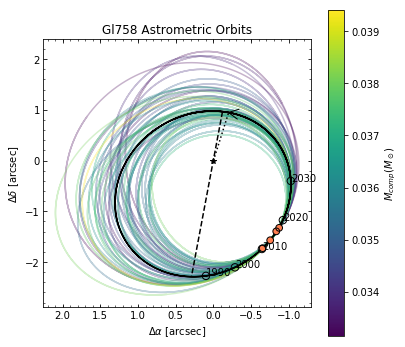

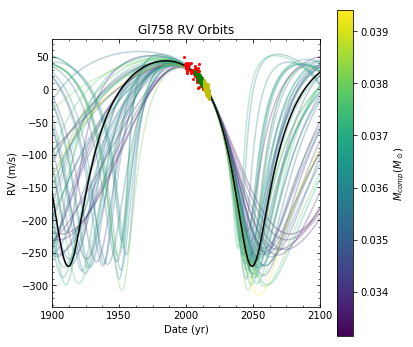

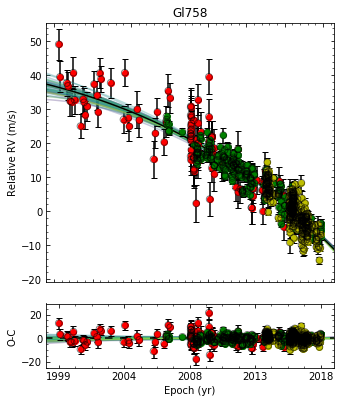

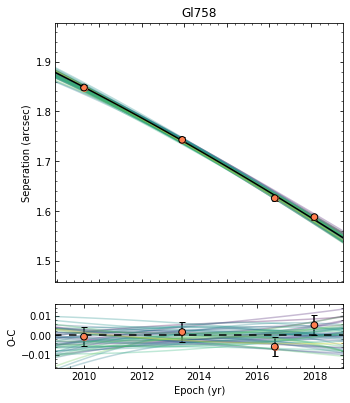

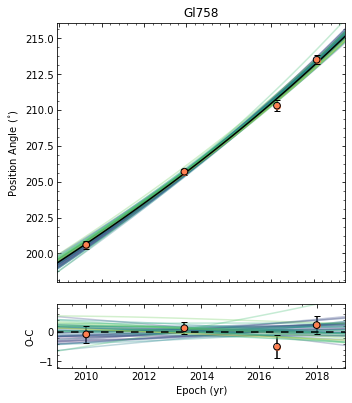

In [45]:
OPs = OrbitPlots('Gl758', 95319, (1900, 2100), 'msec')
OPs.astrometry()
OPs.RV()
OPs.relRV()
OPs.relsep()
OPs.PA()

HD4747

Loading RV data from file HD4747_RV.dat
Loaded data from 1 RV instruments.
Loading astrometric data for 1 planet
Loaded 8 relative astrometric data points from file HD4747_relAST.txt
Loading absolute astrometry data for Hip 3850


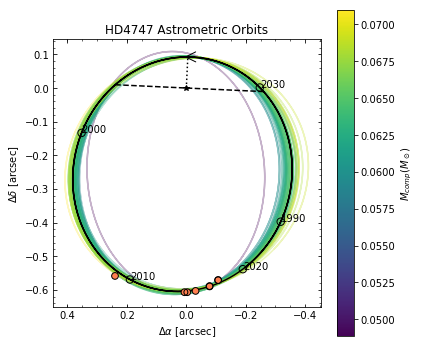

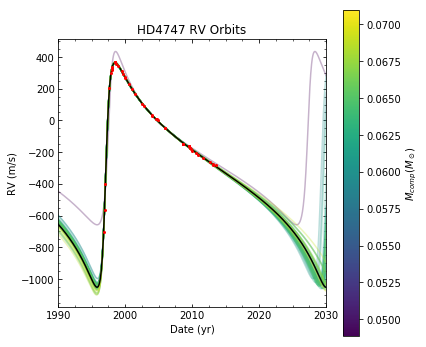

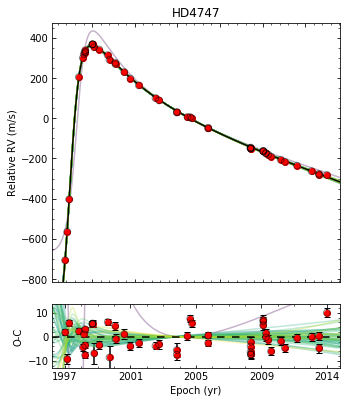

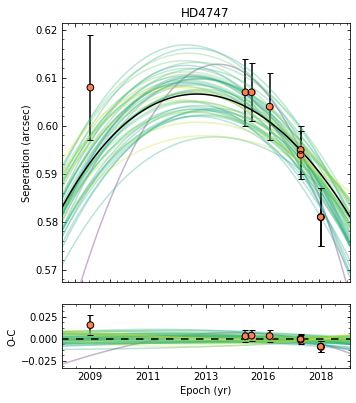

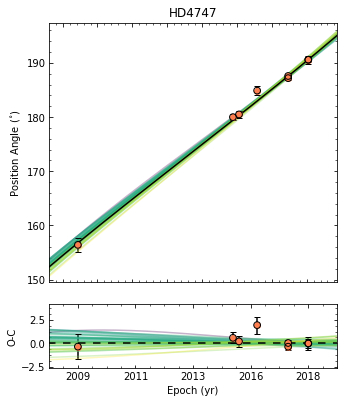

In [38]:
OPs = OrbitPlots('HD4747', 3850, (1990, 2030), 'msec')
OPs.astrometry()
OPs.RV()
OPs.relRV()
OPs.relsep()
OPs.PA()

### Hirsch

HD159062

Loading RV data from file HD159062_RV.dat
Unable to read RV instruments from fourth column.
Assuming all data are from one instrument.
Loading astrometric data for 1 planet
Loaded 7 relative astrometric data points from file HD159062_relAST.txt
Loading absolute astrometry data for Hip 85653


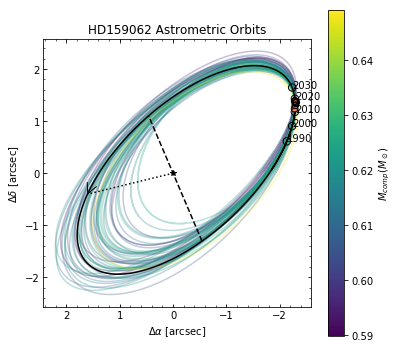

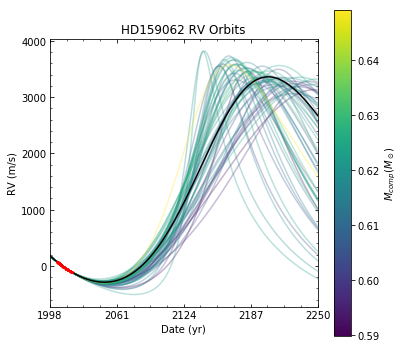

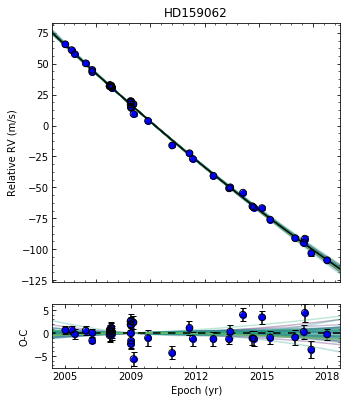

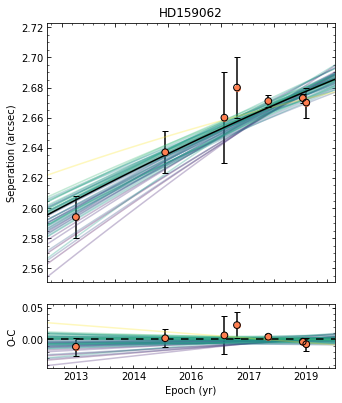

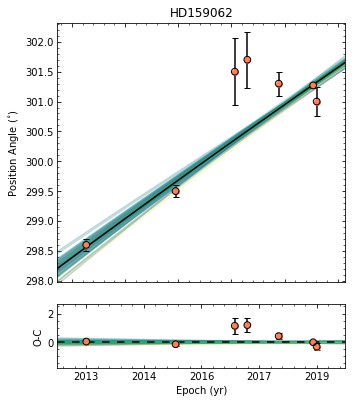

In [39]:
OPs = OrbitPlots('HD159062', 85653, (1998, 2250), 'msec')
OPs.astrometry()
OPs.RV()
OPs.relRV()
OPs.relsep()
OPs.PA()

### Kane

HD45701

Loading RV data from file HD45701_RV.dat
Unable to read RV instruments from fourth column.
Assuming all data are from one instrument.
Unable to load relative astrometry data from file HD45701_relAST.txt
Loading absolute astrometry data for Hip 30480


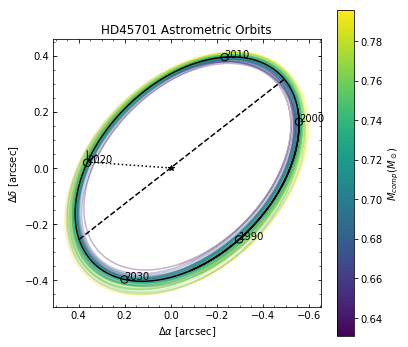

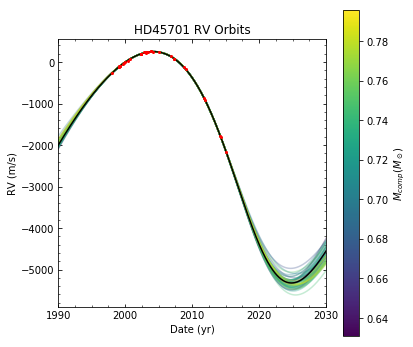

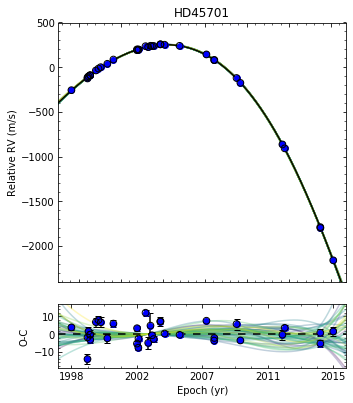

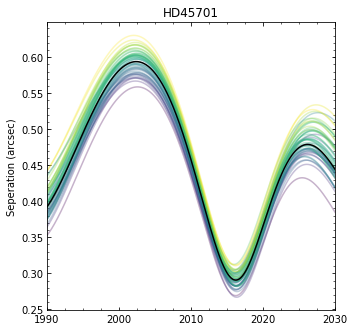

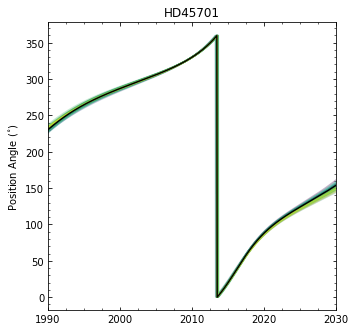

In [24]:
OPs = OrbitPlots('HD45701', 30480, (1990, 2030), 'msec')
OPs.astrometry()
OPs.RV()
OPs.relRV()
OPs.relsep()
OPs.PA()

HD92987

Loading RV data from file HD92987_RV.dat
Unable to read RV instruments from fourth column.
Assuming all data are from one instrument.
Unable to load relative astrometry data from file HD92987_relAST.txt
Loading absolute astrometry data for Hip 52472


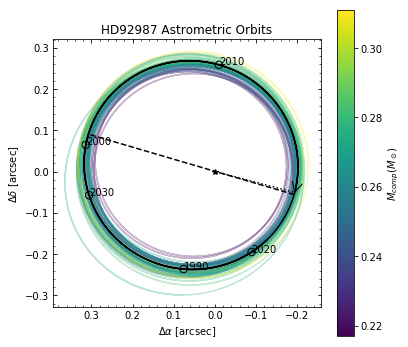

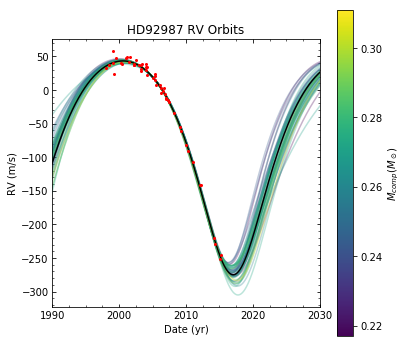

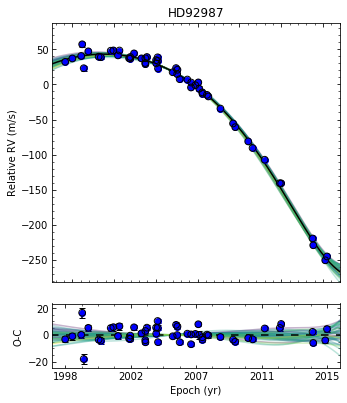

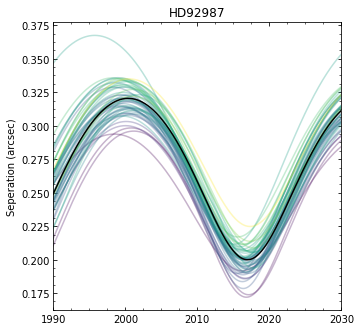

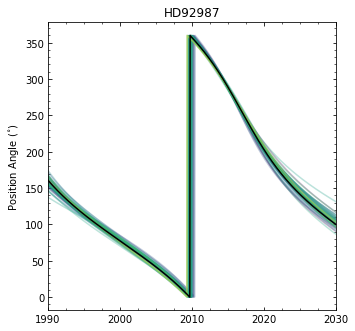

In [25]:
OPs = OrbitPlots('HD92987', 52472, (1990, 2030), 'msec')
OPs.astrometry()
OPs.RV()
OPs.relRV()
OPs.relsep()
OPs.PA()

HD145825

Loading RV data from file HD145825_RV.dat
Unable to read RV instruments from fourth column.
Assuming all data are from one instrument.
Unable to load relative astrometry data from file HD145825_relAST.txt
Loading absolute astrometry data for Hip 79578


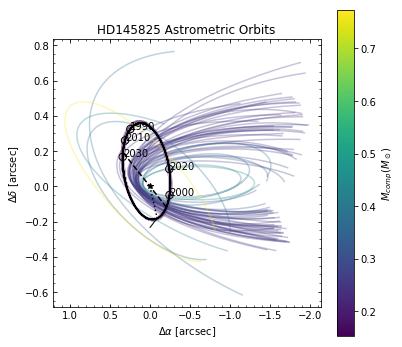

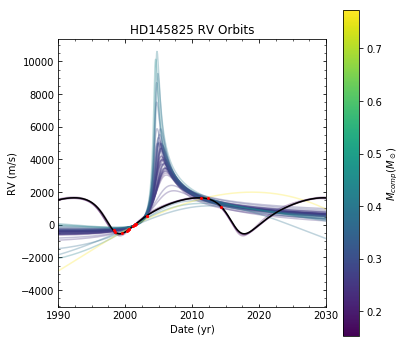

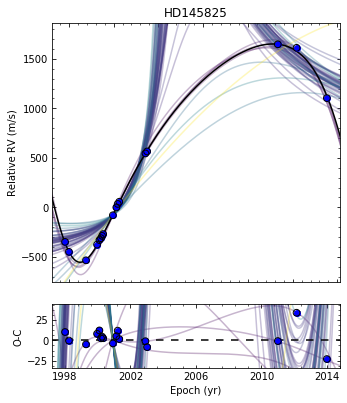

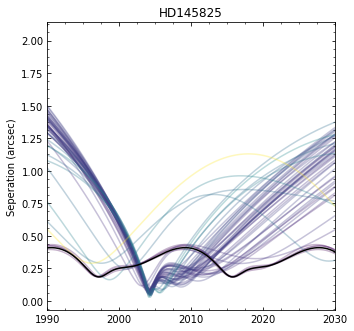

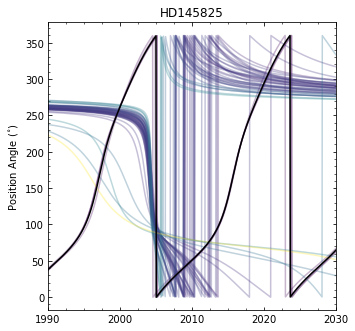

In [26]:
OPs = OrbitPlots('HD145825', 79578, (1990, 2030), 'msec')
OPs.astrometry()
OPs.RV()
OPs.relRV()
OPs.relsep()
OPs.PA()

HD212330

Loading RV data from file HD212330_RV.dat
Unable to read RV instruments from fourth column.
Assuming all data are from one instrument.
Unable to load relative astrometry data from file HD212330_relAST.txt
Loading absolute astrometry data for Hip 110649


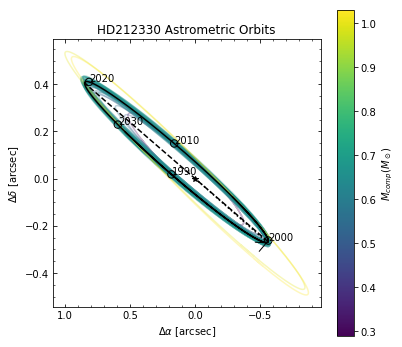

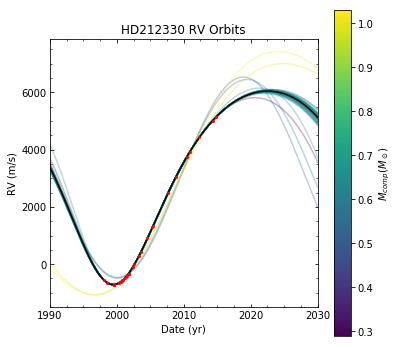

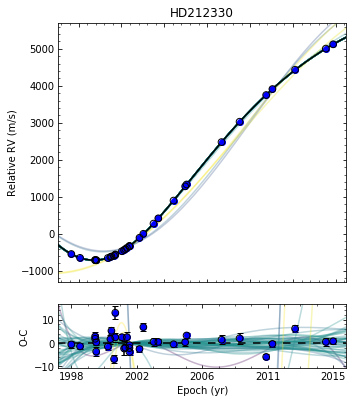

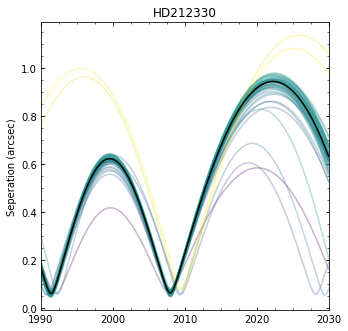

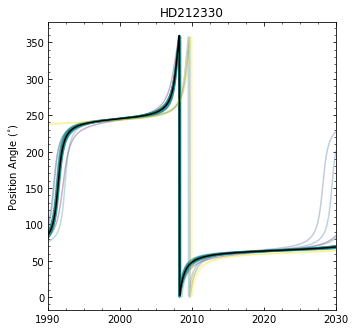

In [27]:
OPs = OrbitPlots('HD212330', 110649, (1990, 2030), 'msec') 
OPs.astrometry()
OPs.RV()
OPs.relRV()
OPs.relsep()
OPs.PA()

HD221420

Loading RV data from file HD221420_RV.dat
Unable to read RV instruments from fourth column.
Assuming all data are from one instrument.
Unable to load relative astrometry data from file HD221420_relAST.txt
Loading absolute astrometry data for Hip 116250


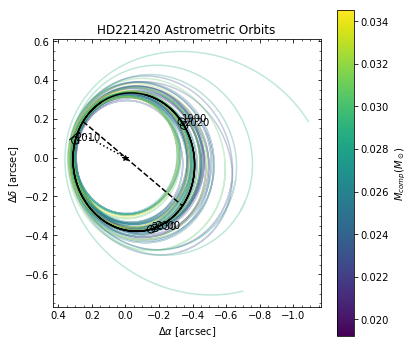

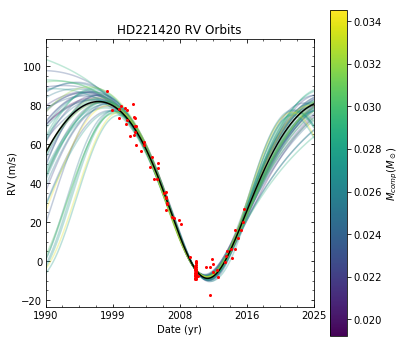

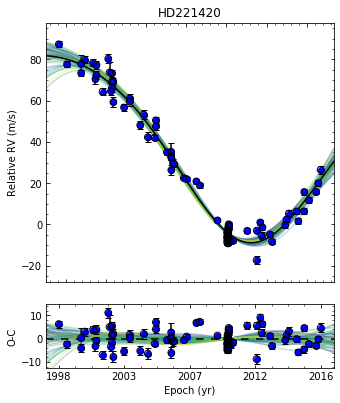

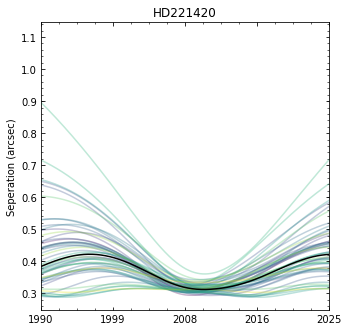

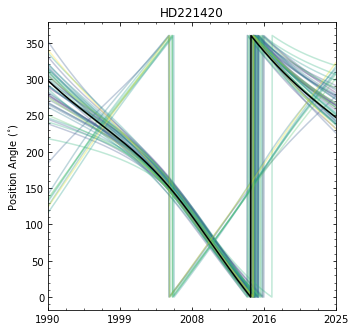

In [28]:
OPs = OrbitPlots('HD221420', 116250, (1990, 2025), 'msec')
OPs.astrometry()
OPs.RV()
OPs.relRV()
OPs.relsep()
OPs.PA()

HD51929

Loading RV data from file HD51929_RV.dat
Unable to read RV instruments from fourth column.
Assuming all data are from one instrument.
Unable to load relative astrometry data from file HD51929_relAST.txt
Loading absolute astrometry data for Hip 33324


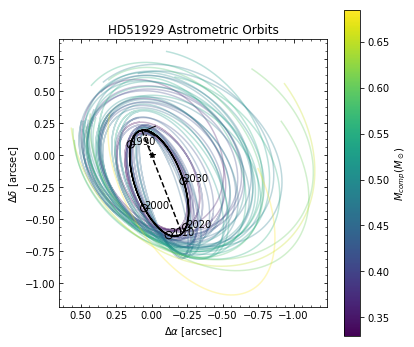

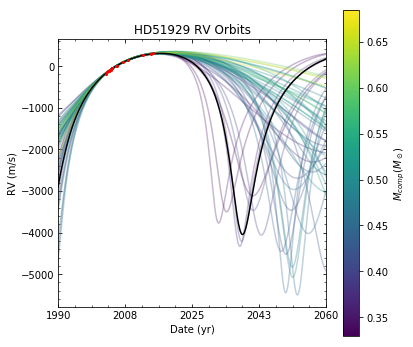

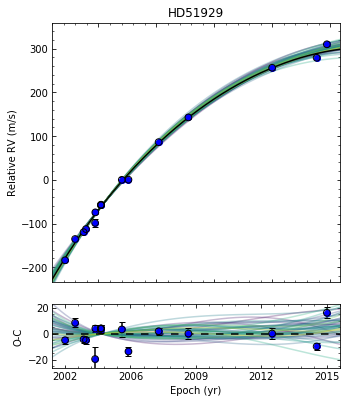

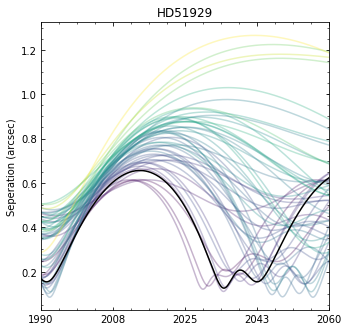

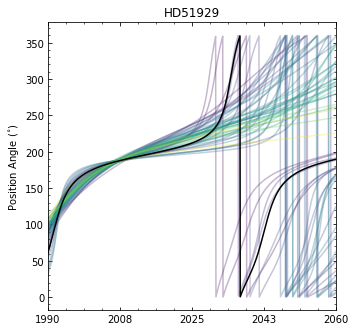

In [29]:
OPs = OrbitPlots('HD51929', 33324, (1990, 2060), 'msec')
OPs.astrometry()
OPs.RV()
OPs.relRV()
OPs.relsep()
OPs.PA()

HD52447

Loading RV data from file HD52447_RV.dat
Unable to read RV instruments from fourth column.
Assuming all data are from one instrument.
Unable to load relative astrometry data from file HD52447_relAST.txt
Loading absolute astrometry data for Hip 33468


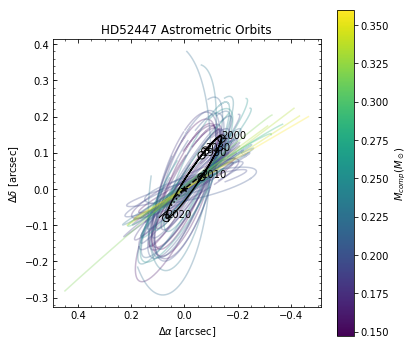

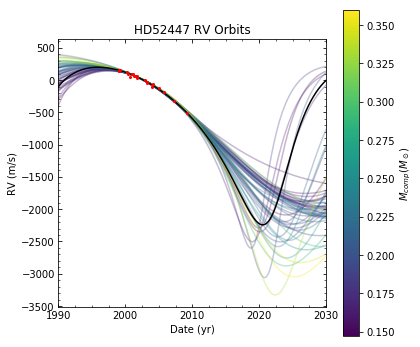

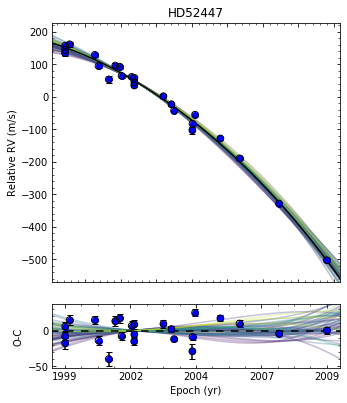

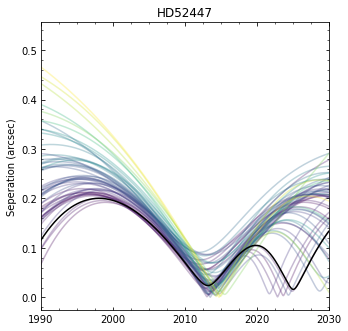

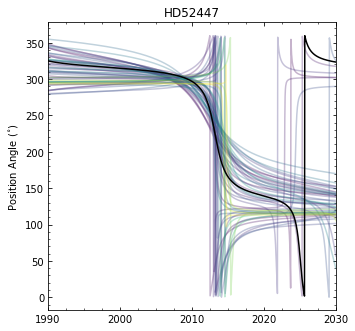

In [30]:
OPs = OrbitPlots('HD52447', 33468, (1990, 2030), 'msec')
OPs.astrometry()
OPs.RV()
OPs.relRV()
OPs.relsep()
OPs.PA()

HD191408

Loading RV data from file HD191408_RV.dat
Unable to read RV instruments from fourth column.
Assuming all data are from one instrument.
Unable to load relative astrometry data from file HD191408_relAST.txt
Loading absolute astrometry data for Hip 99461


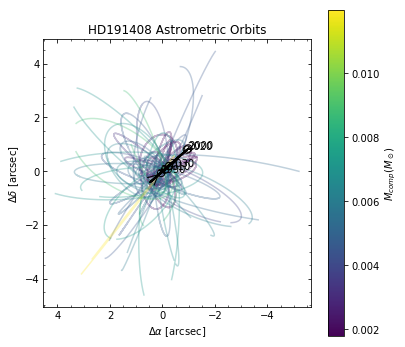

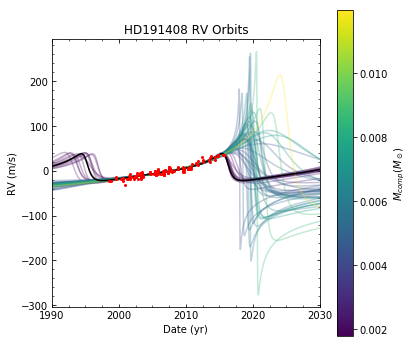

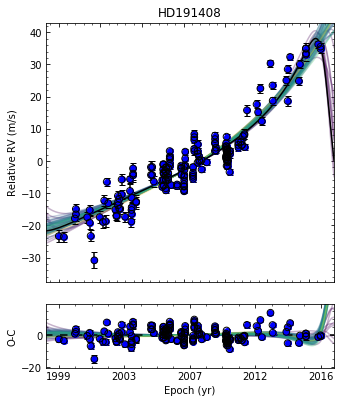

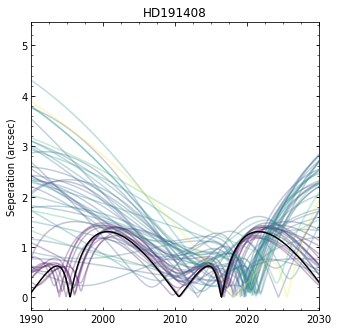

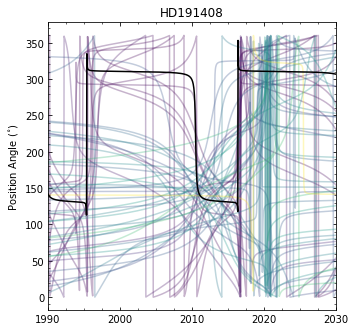

In [31]:
OPs = OrbitPlots('HD191408', 99461, (1990, 2030), 'msec')
OPs.astrometry()
OPs.RV()
OPs.relRV()
OPs.relsep()
OPs.PA()

HD199509

Loading RV data from file HD199509_RV.dat
Unable to read RV instruments from fourth column.
Assuming all data are from one instrument.
Unable to load relative astrometry data from file HD199509_relAST.txt
Loading absolute astrometry data for Hip 104436


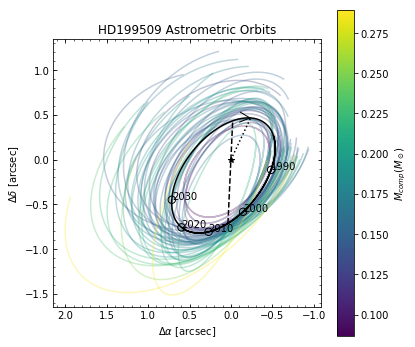

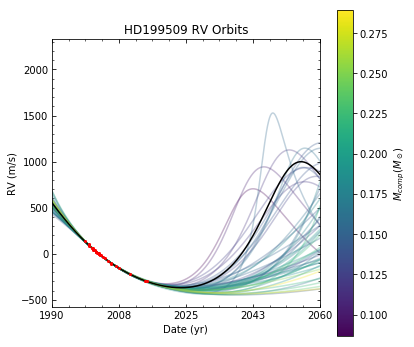

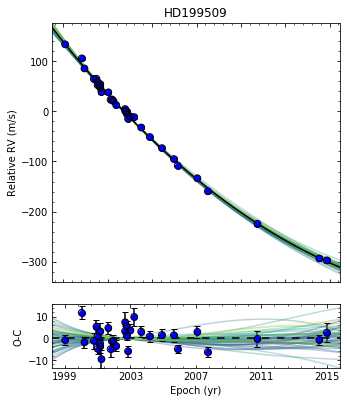

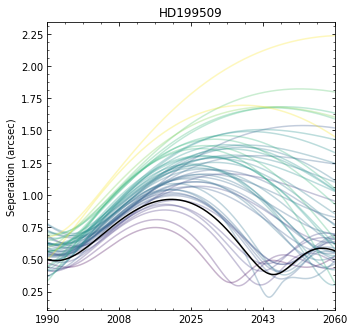

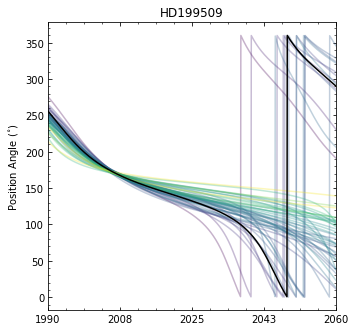

In [32]:
OPs = OrbitPlots('HD199509', 104436, (1990, 2060), 'msec') 
OPs.astrometry()
OPs.RV()
OPs.relRV()
OPs.relsep()
OPs.PA()